# LLM from scratch

The goal is to code from scratch (using Pytorch) a Transformer, more precisely a GPT-like model (using a decoder-only architecture).

In [1]:
import torch
import torch.nn as nn
from torch.nn import functional as F
import matplotlib.pyplot as plt
%matplotlib inline

from tqdm.notebook import trange

What we will do here: train a generative model with political speeches (State of the Union).
The goal is to generate more speeches!

In [88]:
# main hyperparameters
batch_size = 32 # number of sequences processed in parallel
n_token = 512 # number of tokens (used for word level tokenizer)

Note: the hyper parameters were **not** optimised at all! Also, the code runs on CPU, not GPU. It is mostly for educational purposes.

## Part 1: Playing with the dataset

Let's download the dataset.

In [3]:
!wget https://raw.githubusercontent.com/nathanael-fijalkow/llm_mva/main/sotu.txt

--2025-01-07 10:51:12--  https://raw.githubusercontent.com/nathanael-fijalkow/llm_mva/main/sotu.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.108.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1279319 (1,2M) [text/plain]
Saving to: ‘sotu.txt.1’

sotu.txt.1          100%[===================>]   1,22M  31,2KB/s    in 2m 16s  

2025-01-07 10:53:34 (9,18 KB/s) - ‘sotu.txt.1’ saved [1279319/1279319]



In [3]:
with open('sotu.txt', 'r', encoding='utf-8') as f:
    text = f.read()

text = text.lower()
print(text[:1000])

mr. speaker, mr. president, and distinguished members of the house and senate,
honored guests, and fellow citizens: less than 3 weeks ago, i joined you on the
west front of this very building and, looking over the monuments to our proud
past, offered you my hand in filling the next page of american history with a
story of extended prosperity and continued peace. and tonight i'm back to offer
you my plans as well. the hand remains extended; the sleeves are rolled up;
america is waiting; and now we must produce. together, we can build a better
america.

it is comforting to return to this historic chamber. here, 22 years ago, i first
raised my hand to be sworn into public life. so, tonight i feel as if i'm
returning home to friends. and i intend, in the months and years to come, to
give you what friends deserve: frankness, respect, and my best judgment about
ways to improve america's future. in return, i ask for an honest commitment to
our common mission of progress. if we seize the oppor

In [4]:
data_size = len(text)
data_size

1279319

## Part 2: Word-level tokenizer

Instead of working at character level, we will now work at word level. The science of decomposing a text into tokens is a complicated one. Here we use `minbpe`, which implements the Byte Pair Encoding (BPE) algorithm commonly used in LLM tokenization.

In [5]:
from minbpe.minbpe import RegexTokenizer

The tokenizer takes a while to run so let's download a tokenizer (obtained using minbpe).

In [7]:
!wget https://raw.githubusercontent.com/nathanael-fijalkow/llm_mva/main/tok512.model
!wget https://raw.githubusercontent.com/nathanael-fijalkow/llm_mva/main/tok512.vocab

--2025-01-07 10:53:34--  https://raw.githubusercontent.com/nathanael-fijalkow/llm_mva/main/tok512.model
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.108.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2075 (2,0K) [text/plain]
Saving to: ‘tok512.model.1’

tok512.model.1      100%[===================>]   2,03K  --.-KB/s    in 0s      

2025-01-07 10:53:35 (13,5 MB/s) - ‘tok512.model.1’ saved [2075/2075]

--2025-01-07 10:53:35--  https://raw.githubusercontent.com/nathanael-fijalkow/llm_mva/main/tok512.vocab
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.110.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 7727 (7,5K) [text/plain]
Sa

In [6]:
tokenizer = RegexTokenizer()
tokenizer.load("tok512.model")

We encode the entire text dataset and store it into a `torch.Tensor`.

In [7]:
data = torch.tensor(tokenizer.encode(text), dtype=torch.long)
n = int(0.9*len(data))
train_data = data[:n]
val_data = data[n:]

data.shape, data[:50]

(torch.Size([586714]),
 tensor([109, 114,  46, 276, 393, 384, 263,  44, 283, 114,  46, 274, 344, 340,
         300,  44, 279, 295, 383, 290, 117, 287, 258, 100, 283, 409,  98, 381,
         280, 262, 296, 301, 319, 279, 276, 270, 379, 461, 104, 264, 367, 100,
         312, 117, 101, 268, 115,  44, 279, 275]))

In [8]:
test = "hello world"
test_encoded = tokenizer.encode(test)
test_encoded, [tokenizer.decode([x]) for x in test_encoded], tokenizer.decode(test_encoded)

([258, 285, 111, 492], ['he', 'll', 'o', ' world'], 'hello world')

The longest tokens in political speeches according to BPE.

In [9]:
token_list = sorted([tokenizer.decode([x]) for x in range(n_token)], 
                    key=len, 
                    reverse=True)
token_list[:20]

[' America',
 'vernment',
 ' Americ',
 ' people',
 ' nation',
 'ongress',
 ' their',
 ' world',
 'ation',
 ' that',
 'meric',
 ' will',
 ' have',
 ' with',
 ' this',
 ' year',
 ' must',
 ' work',
 ' more',
 ' from']

## Part 3: Evaluating and training with batches

Our models will take as input `context_length` many tokens and produce the next token.

In [12]:
ix = torch.randint(len(data) - context_length, (1,))
sample = data[ix:ix+context_length+1]
sample_list = sample.tolist()
print("Input: ", sample_list[:-1], 
      "\nTarget: ", sample_list[-1])
print("\nHuman version:\nInput: ", tokenizer.decode(sample_list[:-1]), 
      "\nTarget: ", tokenizer.decode([sample_list[-1]]))

Input:  [10, 104, 117, 390, 295, 332, 110, 256, 263, 114, 269, 383, 115, 279, 278, 114, 290, 262, 109, 273, 447, 359, 288, 101, 308, 109, 340, 100, 298, 307, 420, 10, 10, 106, 359, 388, 306, 101, 107, 44, 415, 334, 453, 296, 269, 260, 266, 301, 115, 256, 263, 114, 269, 383, 257, 324, 286, 333, 327, 101, 108, 462, 313, 281] 
Target:  32

Human version:
Input:  
hunt down terrorists and bring them to justice.

middle east

just this week, another horrendous terrorist act in israel killed 
Target:   


In [113]:
def get_batch(split, context_length):
    data = train_data if split == 'train' else val_data
    ix = torch.randint(len(data) - context_length - 1, (batch_size,))
    X = torch.stack([data[i:i+context_length] for i in ix])
    Y = torch.stack([data[i+1:i+context_length+1] for i in ix])
    return X, Y

X,Y = get_batch("train", 8)
X.shape, Y.shape

(torch.Size([32, 8]), torch.Size([32, 8]))

We illustrate below how the cross entropy loss is computed along batches (as the mean over the batches). The same works for most functions in Pytorch, which means that writing code for batches is almost as easy as without!

In [14]:
batch_size_test = 3
number_classes_test = 5

logits = torch.randn(batch_size_test, number_classes_test)
target = torch.randint(number_classes_test, (batch_size_test,), dtype=torch.int64)
loss = F.cross_entropy(logits, target)
print("logits: ", logits, "\ntarget: ", target, "\nloss: ", loss.item())

logits:  tensor([[ 0.3869, -0.8313,  0.8653, -0.1002, -1.3165],
        [-0.9443,  0.3286,  0.7484, -0.9152,  0.6241],
        [-0.3835, -1.5698, -1.4014,  1.3672,  0.3628]]) 
target:  tensor([4, 2, 1]) 
loss:  2.5079784393310547


Let us write the boilerplate code for models.

In [116]:
@torch.no_grad()
def estimate_loss(model, eval_iters, context_length):
    out = {}
    for split in ['train', 'val']:
        losses = torch.zeros(eval_iters)
        for k in range(eval_iters):
            X, Y = get_batch(split, context_length)
            logits, loss = model(X, Y)
            losses[k] = loss.item()
        out[split] = losses.mean()
    return out

In [117]:
def train(model, n_iterations = 10000, learning_rate = 1e-3, eval_interval = 1000, eval_iters = 100):
    # create a PyTorch optimizer
    optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)

    for iter in range(n_iterations):
        # every once in a while evaluate the loss on train and validation sets
        if iter % eval_interval == 0 or iter == n_iterations - 1:
            losses = estimate_loss(model, eval_iters, model.context_length)
            print(f"step {iter}: train loss {losses['train']:.4f}, validation loss {losses['val']:.4f}")

        X,Y = get_batch("train", model.context_length)
        _, loss = model(X, Y)
        optimizer.zero_grad(set_to_none=True)
        loss.backward()
        optimizer.step()

## Part 4: A Multi Layer Perceptron (MLP) model

We essentially implement the model from the paper "**A Neural Probabilistic Language Model**" by Bengio et al from 2003.

The first component is an `Embedding` layer: this is simply a lookup table, as illustrated below. It maps every token to a vector in fixed dimension. Since the dimension is much smaller than the number of tokens, intuitively the embedding layer will have to map similar tokens to similar vectors.

In [17]:
n_token_test = 3
n_embed_test = 4

embedding = torch.nn.Embedding(n_token_test, n_embed_test)
print("Weights of the embedding:\n", embedding.weight)
print("Result of embedding token number 1:\n", embedding(torch.tensor([1])))

Weights of the embedding:
 Parameter containing:
tensor([[ 0.5276, -0.9439, -0.4594, -0.6109],
        [-0.1154, -0.7300, -0.6533,  1.9877],
        [ 0.7099,  2.0952,  1.9040,  0.5473]], requires_grad=True)
Result of embedding token number 1:
 tensor([[-0.1154, -0.7300, -0.6533,  1.9877]], grad_fn=<EmbeddingBackward0>)


Let us describe how the model works. 

Recall that a datapoint is a tensor `x` of size `context_length`. Each of the `context_length` token is embedded, yielding a tensor of dimension `n_embed`. The resulting embeddings are concatenated to form a tensor of dimension `context_length * n_embed`, and then fed into a standard feed forward network. This is illustrated below (minus the network), with batches.

In [18]:
batch_size_test = 2
context_length_test = 3
n_token_test = 4
n_embed_test = 5

blank_token_test = n_token_test

idx = torch.randint(high = n_token_test, size = (batch_size_test, context_length_test))
print("Input tokens:\n", idx)
embedding = torch.nn.Embedding(n_token_test + 1, n_embed_test)
print("Weights of the embedding:\n", embedding.weight)

print("*******************\n")

x = embedding(idx)
x.shape, x

Input tokens:
 tensor([[2, 3, 3],
        [1, 3, 0]])
Weights of the embedding:
 Parameter containing:
tensor([[-5.9224e-02,  1.5527e+00,  2.0119e-01,  9.6450e-01,  4.9937e-01],
        [ 1.1425e+00, -2.7150e-01, -2.3825e+00,  3.7304e-01, -3.9982e-01],
        [-2.8016e-04,  1.1573e+00,  1.3140e+00, -1.2783e-01,  5.7593e-01],
        [-5.7148e-01,  2.2201e-02, -8.6830e-02,  3.9536e-01, -8.4499e-01],
        [-9.7674e-01,  2.7461e+00,  1.2281e+00, -1.2290e+00,  3.8473e-02]],
       requires_grad=True)
*******************



(torch.Size([2, 3, 5]),
 tensor([[[-2.8016e-04,  1.1573e+00,  1.3140e+00, -1.2783e-01,  5.7593e-01],
          [-5.7148e-01,  2.2201e-02, -8.6830e-02,  3.9536e-01, -8.4499e-01],
          [-5.7148e-01,  2.2201e-02, -8.6830e-02,  3.9536e-01, -8.4499e-01]],
 
         [[ 1.1425e+00, -2.7150e-01, -2.3825e+00,  3.7304e-01, -3.9982e-01],
          [-5.7148e-01,  2.2201e-02, -8.6830e-02,  3.9536e-01, -8.4499e-01],
          [-5.9224e-02,  1.5527e+00,  2.0119e-01,  9.6450e-01,  4.9937e-01]]],
        grad_fn=<EmbeddingBackward0>))

In [118]:
class MLP(nn.Module):
    def __init__(self, context_length, n_embed, n_embed2):
        super().__init__()
        self.token_embedding_table = nn.Embedding(n_token, n_embed)
        self.net = nn.Sequential(
            nn.Linear(context_length * n_embed, n_embed2),
            nn.Tanh(),
            nn.Linear(n_embed2, n_token)
        )
        self.context_length = context_length

    def forward(self, idx, y=None):
        B, T = idx.shape
        # if training: B = batch_size, otherwise B = 1
        # T = context_length

        x = self.token_embedding_table(idx).view(B, self.context_length * n_embed)
        # x.shape = (B, context_length * n_embed)
        
        logits = self.net(x) 
        # logits.shape = (B, n_token)
        
        if y is None:
            loss = None
        else:
            # B = batch_size
            # y.shape = (batch_size, context_length)
            logits = logits.view(batch_size, n_token)
            y = y[:,-1].view(batch_size)
            loss = F.cross_entropy(logits, y)

        return logits, loss 

In [127]:
model = MLP(context_length = 16, 
            n_embed = 32, 
            n_embed2 = 64)
print(sum(p.numel() for p in model.parameters())/1e6, ' M parameters')

0.230016  M parameters


In [128]:
def generate_MLP(model, max_new_tokens = 2000, prompt = "", topk = 5):
    context_length = model.context_length
    prompt = " " * (context_length - len(prompt)) + prompt
    idx = torch.ones((1,context_length), dtype=torch.long) * tokenizer.encode(prompt)[0]
    for _ in range(max_new_tokens):
        # we crop at context_length
        idx_cond = idx[:, -context_length:]
        # forward pass
        logits, _ = model(idx_cond)

        # topk
        v, _ = torch.topk(logits, topk)
        logits[logits < v[:, [-1]]] = -float('Inf')
        # apply softmax to convert logits to (normalized) probabilities
        probs = F.softmax(logits, dim=-1)
        # sample from the distribution
        idx_next = torch.multinomial(probs, num_samples=1).view((1,1))

        # greedy decoding is equivalent to topk = 1
        # idx_next = torch.argmax(logits, dim=-1).view((1,1))
        
        # append sampled index to the running sequence and continue
        idx = torch.cat((idx, idx_next), dim=1)
    return tokenizer.decode(idx[0][context_length:].tolist())

In [129]:
print(generate_MLP(model, max_new_tokens = 50, prompt = "dear fellow americans, "))

j�Jilif all/ifse have�ore as� Americardnt�idg l�x pro;rom�=thortthe m�`owimR yreldseimpisand


In [130]:
train(model, n_iterations = 20000, learning_rate = 5e-4, eval_interval = 1000, eval_iters = 100)

step 0: train loss 6.2764, validation loss 6.2774
step 1000: train loss 4.8814, validation loss 4.8903
step 2000: train loss 4.3917, validation loss 4.4710
step 3000: train loss 4.0791, validation loss 4.2085
step 4000: train loss 3.8821, validation loss 4.0824
step 5000: train loss 3.8014, validation loss 4.0356
step 6000: train loss 3.6856, validation loss 3.9203
step 7000: train loss 3.6068, validation loss 3.8363
step 8000: train loss 3.5774, validation loss 3.8096
step 9000: train loss 3.5206, validation loss 3.7826
step 10000: train loss 3.4492, validation loss 3.7610
step 11000: train loss 3.4368, validation loss 3.6716
step 12000: train loss 3.3237, validation loss 3.6591
step 13000: train loss 3.3994, validation loss 3.6752
step 14000: train loss 3.3380, validation loss 3.6276
step 15000: train loss 3.2473, validation loss 3.6540
step 16000: train loss 3.2756, validation loss 3.6296
step 17000: train loss 3.2547, validation loss 3.6669
step 18000: train loss 3.1900, validation

In [131]:
print(generate_MLP(model, max_new_tokens = 200, prompt = "dear fellow americans, "))

ital states
americans. we must do not together america's begines
and the
ween to the marketerous of theself of
machnol, and 20, 1980
sovided the funds to believe america. we have aftone, spoi've sponerible, and to aved to the
americans to
ftonight, iraq, the 20 year, the
relation of the world. i
noted thember. we have alooking the soutts of the mankle
magy of america, america's the world, "0 year. the families


## Part 6: Attention mechanism

### A self-attention head

Attention is a **communication mechanism**. In our case, the tokens communicate information and determine which tokens are relevant for them.

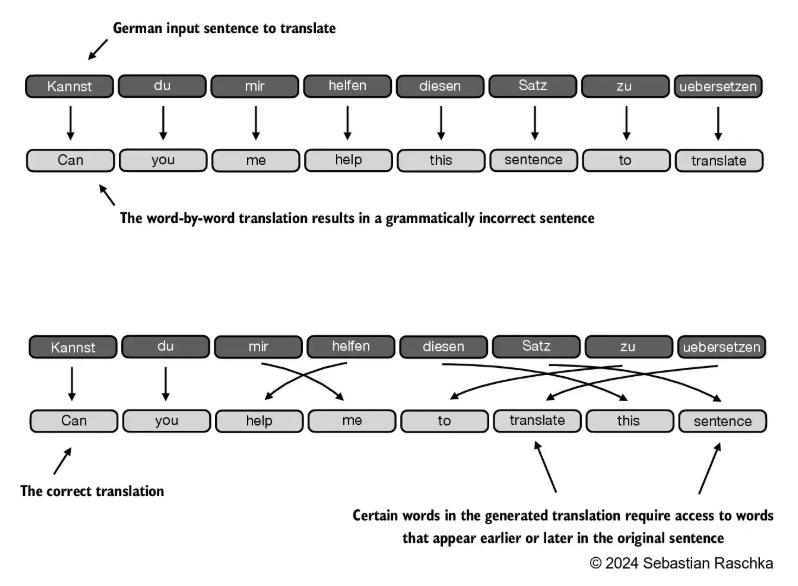

The input of the head is for each token a tensor of dimension `head_input_dim`, forming a tensor `x: (context_length,head_input_dim)`.
The goal is to compute for each token a context tensor, so a tensor `z: (context_length,head_output_dim)`. The context tensor for token `i` will be a weighted average of all input tensors multiplied by their attention weights. More precisely, for computing the context tensor for token `i`, we compute the attention of `i` with each token `j`, and multiply the input of `j` by the attentin of `i` for `j`.

In [166]:
class Head(nn.Module):
    def __init__(self, context_length, head_input_dim, head_size, head_output_dim):
        super().__init__()
        self.key = nn.Linear(head_input_dim, head_size, bias=False)
        self.query = nn.Linear(head_input_dim, head_size, bias=False)
        self.value = nn.Linear(head_input_dim, head_output_dim, bias=False)

        # Some Pytorch way of defining a matrix without trainable parameters 
        self.register_buffer('tril', torch.tril(torch.ones(context_length, context_length)))     
        
        self.context_length = context_length
        self.head_input_dim = head_input_dim
        self.head_size = head_size
        self.head_output_dim = head_output_dim

    def forward(self, x):
        B, T, C = x.shape
        # if training: B = batch_size, else B = 1
        # T = context_length
        # I = head_input_dim
        # H = head_size
        # O = head_output_dim
        
        k = self.key(x)   # (B, T, H)
        q = self.query(x) # (B, T, H)
        v = self.value(x) # (B, T, O)
        attention_scores = q @ k.transpose(1,2) # (B, T, H) @ (B, H, T) -> (B, T, T)
        mask = torch.triu(torch.ones(self.context_length, self.context_length), diagonal=1)
        masked_attention_scores = attention_scores.masked_fill(self.tril[:T, :T] == 0, float('-inf')) # (B, T, T)
        attention_weights = torch.softmax(masked_attention_scores * self.head_size**-0.5, dim=-1) # (B, T, T)
        context_vectors = attention_weights @ v # (B, T, T) @ (B, T, O) -> (B, T, O)
        return context_vectors

**Positional encoding**: There is no notion of space, the attention mechanism acts over a **set** of vectors. This is why we need to positionally encode tokens. Two solutions:
* Learning an embedding of positions
* Using a fixed embedding

Here we use the first solution but illustrate the second one below.

Suppose that the input representation $X \in \mathbb{R}^{n \times d}$ contains the $d$-dimensional embeddings for $n$ tokens of a sequence. 
The positional encoding outputs $X + P$ using a positional embedding matrix $P$ of the same shape, whose element on the $i$-th row and the $2j$-th or the $2j+1$-th column is
$$P(i,2j) = \text{sin}\left( \frac{i}{10000^{2j / d}} \right)$$
$$P(i,2j+1) = \text{cos}\left( \frac{i}{10000^{2j / d}} \right)$$

Credit for the code and picture: Jonathan Kernes, https://towardsdatascience.com/master-positional-encoding-part-i-63c05d90a0c3

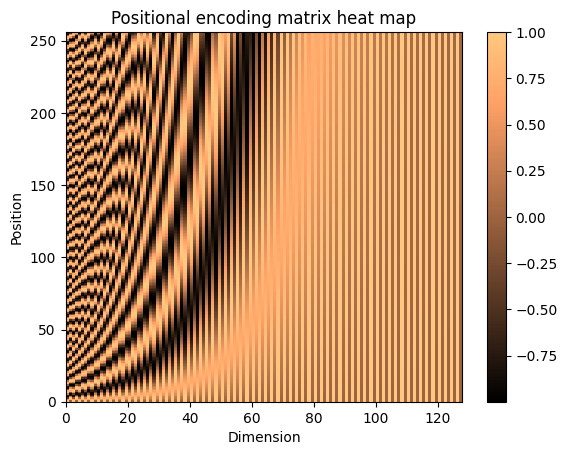

In [26]:
import numpy as np

def positional_encoding(max_position, model_dim, min_freq=1e-4):
    position = np.arange(max_position)
    freqs = min_freq**(2*(np.arange(model_dim)//2)/model_dim)
    pos_enc = position.reshape(-1,1)*freqs.reshape(1,-1)
    pos_enc[:, ::2] = np.cos(pos_enc[:, ::2])
    pos_enc[:, 1::2] = np.sin(pos_enc[:, 1::2])
    return pos_enc
    
model_dim = 128
max_pos = 256
mat = positional_encoding(max_pos, model_dim)
plt.pcolormesh(mat, cmap='copper')
plt.xlabel('Dimension')
plt.xlim((0, model_dim))
plt.ylabel('Position')
plt.title("Positional encoding matrix heat map")
plt.colorbar()
plt.show()

This model is just an illustration of what can be done with a single head plus positional encoding.

In [167]:
class SingleHeadPositional(nn.Module):
    
    def __init__(self, context_length, n_embed, head_size, head_output_dim):
        super().__init__()
        self.token_embedding_table = nn.Embedding(n_token, n_embed)
        self.position_embedding_table = nn.Embedding(context_length, n_embed)
        self.self_attention_head = Head(context_length = context_length,
                                        head_input_dim = n_embed, 
                                        head_size = head_size, 
                                        head_output_dim = head_output_dim)
        self.last_head = nn.Linear(head_output_dim, n_token)
        self.context_length = context_length

    def forward(self, idx, y=None):
        B, T = idx.shape
        # T = context_length        
        # I = head_input_dim = n_embed
        # H = head_size
        # O = head_output_dim

        tok_emb = self.token_embedding_table(idx) # (B, T, I)
        pos_emb = self.position_embedding_table(torch.arange(T)) # (T, I)
        x = tok_emb + pos_emb # (B, T, I)

        x = self.self_attention_head(x) # (B, T, H)
        logits = self.last_head(x) # (B, T, n_token)

        if y is None:
            loss = None
        else:
            logits = logits.view(B * T, n_token)
            y = y.view(B * T)
            loss = F.cross_entropy(logits, y)
        return logits, loss        

In [168]:
def generate(model, max_new_tokens = 2000, topk = 5):
    idx = torch.ones((1, context_length), dtype=torch.long) * tokenizer.encode("\n")[0]
    for _ in range(max_new_tokens):
        # we crop at context_length
        idx_cond = idx[:, -model.context_length:]
        # forward pass
        logits, _ = model(idx_cond)
        # use the logits for the full context
        logits = logits[:,-1,:]

        # topk
        v, _ = torch.topk(logits, topk)
        logits[logits < v[:, [-1]]] = -float('Inf')
        # apply softmax to convert logits to (normalized) probabilities
        probs = F.softmax(logits, dim=-1)
        # sample from the distribution
        idx_next = torch.multinomial(probs, num_samples=1).view((1,1))
        # append sampled index to the running sequence and continue
        idx = torch.cat((idx, idx_next), dim=1)
    return tokenizer.decode(idx[0][model.context_length:].tolist())

In [169]:
model = SingleHeadPositional(context_length = 32, 
                             n_embed = 64, 
                             head_size = 16, 
                             head_output_dim = 32)
print(sum(p.numel() for p in model.parameters())/1e6, ' M parameters')

0.055808  M parameters


In [173]:
train(model, n_iterations = 20000, learning_rate = 1e-3, eval_interval = 1000, eval_iters = 100)

step 0: train loss 6.2444, validation loss 6.2448
step 1000: train loss 4.2565, validation loss 4.3477
step 2000: train loss 3.8735, validation loss 4.0009
step 3000: train loss 3.7491, validation loss 3.9167
step 4000: train loss 3.6927, validation loss 3.8331
step 5000: train loss 3.6429, validation loss 3.8051
step 6000: train loss 3.6167, validation loss 3.7932
step 7000: train loss 3.5815, validation loss 3.7584
step 8000: train loss 3.5769, validation loss 3.7482
step 9000: train loss 3.5545, validation loss 3.7355
step 10000: train loss 3.5345, validation loss 3.7274
step 11000: train loss 3.5348, validation loss 3.7077
step 12000: train loss 3.5146, validation loss 3.6987
step 13000: train loss 3.5177, validation loss 3.7032
step 14000: train loss 3.5168, validation loss 3.6890
step 15000: train loss 3.5013, validation loss 3.6927
step 16000: train loss 3.5065, validation loss 3.6842
step 17000: train loss 3.4935, validation loss 3.6861
step 18000: train loss 3.4983, validation

In [174]:
print(generate(model, max_new_tokens = 200))

, importunity of our over 1978198000,00 marked, we must be americage, 1980, and
wecents, to the preseration and
the
movest, the
thermonger, the firmange, we have
ces
apartany and americage. 19800, and 19, we must do not
aboust the perals of firstitments, and 1980. we will conflation of our families, $21000 preemental
ptain, i warne of the country to
d


### From single head to multi headed attention

In [32]:
class MultiHeadAttention(nn.Module):
    """ multiple heads of self-attention in parallel """

    def __init__(self, context_length, n_head, head_size, head_output_dim):
        super().__init__()
        self.heads = nn.ModuleList([Head(context_length = context_length,
                                         head_input_dim = n_embed, 
                                         head_size = head_size, 
                                         head_output_dim = head_output_dim) for _ in range(n_head)])
        self.proj = nn.Linear(n_head * head_output_dim, n_embed)

    def forward(self, x):
        out = torch.cat([h(x) for h in self.heads], dim=-1)
        out = self.proj(out)
        return out

We enrich the previous model with parallel heads, called multi head.

In [33]:
class MultiHeadPositional(nn.Module):
    
    def __init__(self, n_head, head_size, head_output_dim):
        super().__init__()
        self.token_embedding_table = nn.Embedding(n_token, n_embed)
        self.position_embedding_table = nn.Embedding(context_length, n_embed)
        self.self_attention_heads = MultiHeadAttention(n_head = n_head,
                                                      head_size = head_size,
                                                      head_output_dim = head_output_dim) 
        self.last_head = nn.Linear(n_embed, n_token)

    def forward(self, idx, y=None):
        B, T = idx.shape
        # B = either batch_size or 1
        # T = context_length
        # I = head_input_dim 
        
        tok_emb = self.token_embedding_table(idx) # (B, T, I)
        pos_emb = self.position_embedding_table(torch.arange(T)) # (T, I)
        x = tok_emb + pos_emb # (B, T, I)

        x = self.self_attention_heads(x) # (B, T, n_embed)
        logits = self.last_head(x) # (B, T, n_token)
        
        if y is None:
            loss = None
        else:
            logits = logits.view(B * T, n_token)
            y = y.view(B * T)
            loss = F.cross_entropy(logits, y)
        return logits, loss        

In [34]:
model = MultiHeadPositional(n_head = 6, 
                            head_size = 16,
                           head_output_dim = 16)
print(sum(p.numel() for p in model.parameters())/1e6, ' M parameters')
train(model, n_iterations = 20000, learning_rate = 1e-3, eval_interval = 1000, eval_iters = 100)
print(generate(model, max_new_tokens = 200))

0.094784  M parameters
step 0: train loss 6.2495, validation loss 6.2508
step 1000: train loss 4.0522, validation loss 4.1497
step 2000: train loss 3.8907, validation loss 4.0228
step 3000: train loss 3.8322, validation loss 3.9713
step 4000: train loss 3.7870, validation loss 3.9312
step 5000: train loss 3.7660, validation loss 3.9071
step 6000: train loss 3.7407, validation loss 3.8881
step 7000: train loss 3.7134, validation loss 3.8776
step 8000: train loss 3.7052, validation loss 3.8576
step 9000: train loss 3.6488, validation loss 3.8201
step 10000: train loss 3.5466, validation loss 3.7271
step 11000: train loss 3.4769, validation loss 3.6649
step 12000: train loss 3.4319, validation loss 3.6402
step 13000: train loss 3.3976, validation loss 3.6099
step 14000: train loss 3.3734, validation loss 3.5896
step 15000: train loss 3.3748, validation loss 3.5744
step 16000: train loss 3.3490, validation loss 3.5718
step 17000: train loss 3.3474, validation loss 3.5631
step 18000: train 

## Some deep learning magic to make training easier

### Normalization layers

In [35]:
class LayerNorm(nn.Module):
    def __init__(self, dim, eps=1e-5, momentum=0.1):
        self.eps = eps
        self.gamma = torch.ones(dim)
        self.beta = torch.zeros(dim)

    def __call__(self, x):
        xmean = x.mean(1, keepdim=True) # batch mean
        xvar = x.var(1, keepdim=True) # batch variance
        xhat = (x - xmean) / torch.sqrt(xvar + self.eps) # normalize to unit variance
        self.out = self.gamma * xhat + self.beta
        return self.out

    def parameters(self):
        return [self.gamma, self.beta]

In [36]:
module = LayerNorm(100)
x = torch.randn(32, 100) # batch size 32 of 100-dimensional vectors
x = module(x)
x.shape

torch.Size([32, 100])

We compute the mean and standard deviation of one (the first) feature across all batch inputs:

In [37]:
x[:,0].mean(), x[:,0].std()
# NOT normalised

(tensor(-0.1572), tensor(1.1475))

Now, the mean and standard deviation of the features for a single input from the batch:

In [38]:
x[0,:].mean(), x[0,:].std()
# normalised

(tensor(-1.4305e-08), tensor(1.0000))

### Sequential blocks

In [39]:
class FeedFoward(nn.Module):
    """ a simple linear layer followed by a non-linearity """

    def __init__(self, n_embed2, n_embed = n_embed):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(n_embed, n_embed2),
            nn.Tanh(),
            nn.Linear(n_embed2, n_embed),
        )

    def forward(self, x):
        return self.net(x)

In [40]:
class Block(nn.Module):
    """ Transformer block: communication followed by computation """

    def __init__(self, n_head, head_size, head_output_dim, n_embed2):
        super().__init__()
        self.self_attention_heads = MultiHeadAttention(n_head = n_head,
                                                       head_size = head_size,
                                                       head_output_dim = head_output_dim)
        self.ffwd = FeedFoward(n_embed2 = n_embed2, n_embed = n_embed)
        self.ln1 = nn.LayerNorm(n_embed)
        self.ln2 = nn.LayerNorm(n_embed)

    def forward(self, x):
        # here are skip connections, also called residual connections
        # they help training deep neural networks by adding a pathway to the input
        x = x + self.self_attention_heads(x)

        # normalization layer; recent implementations put them before self attention heads!
        x = self.ln1(x)
        
        # and again skip connections:
        x = x + self.ffwd(x)

        # and again normalization layer
        x = self.ln2(x)

        return x

This is the full model, almost as in the **Attention is all you need** paper (see below for differences).

In [ ]:
@dataclass
class GPTConfig:
    context_length: int = 1024
    n_layer: int = 12
    n_head: int = 12
    n_embed: int = 768
    dropout: float = 0.0

In [41]:
class LanguageModel(nn.Module):

    def __init__(self, 
                 context_length,
                 n_head, 
                 head_size, 
                 head_output_dim, 
                 n_embed,
                 n_embed2, 
                 n_blocks):
        super().__init__()
        self.token_embedding_table = nn.Embedding(n_token, n_embed)
        self.position_embedding_table = nn.Embedding(context_length, n_embed)
        self.blocks = nn.Sequential(*[Block(n_head, head_size) for _ in range(n_blocks)])
        self.ln_f = nn.LayerNorm(n_embed)
        self.lm_head = nn.Linear(n_embed, n_token)

    def forward(self, x, y=None):
        B, T = x.shape
        # T = context_length
        # I = n_embed

        tok_emb = self.token_embedding_table(x) # (B, T, I)
        pos_emb = self.position_embedding_table(torch.arange(T)) # (T, I)
        x = tok_emb + pos_emb # (B, T, I)
        x = self.blocks(x) # (B, T, I)
        x = self.ln_f(x) # (B, T, I)
        logits = self.lm_head(x) # (B, T, n_token)

        if y is None:
            loss = None
        else:
            B, T, _ = logits.shape
            logits = logits.view(B*T, n_token)
            y = y.view(B*T)
            loss = F.cross_entropy(logits, y)

        return logits, loss

In [42]:
model = LanguageModel(context_length = 64,
                      n_head = 6, 
                      head_size = 16,
                      head_output_dim = 16,
                      n_embed = 64,
                      n_embed2 = 4 * 64,
                      n_blocks = 4)
print(sum(p.numel() for p in model.parameters())/1e6, ' M parameters')
train(model, n_iterations = 20000, learning_rate = 6e-4, eval_interval = 1000, eval_iters = 100)

0.302208  M parameters
step 0: train loss 6.3860, validation loss 6.3881
step 1000: train loss 3.4154, validation loss 3.6061
step 2000: train loss 2.9998, validation loss 3.2779
step 3000: train loss 2.7973, validation loss 3.1204
step 4000: train loss 2.7156, validation loss 3.0685
step 5000: train loss 2.6582, validation loss 3.0299
step 6000: train loss 2.5890, validation loss 2.9910
step 7000: train loss 2.5543, validation loss 2.9850
step 8000: train loss 2.5231, validation loss 2.9606
step 9000: train loss 2.4993, validation loss 2.9423
step 10000: train loss 2.4668, validation loss 2.9475
step 11000: train loss 2.4529, validation loss 2.9340
step 12000: train loss 2.4318, validation loss 2.9269
step 13000: train loss 2.4242, validation loss 2.9210
step 14000: train loss 2.4001, validation loss 2.9397
step 15000: train loss 2.3870, validation loss 2.8970
step 16000: train loss 2.3748, validation loss 2.9293
step 17000: train loss 2.3644, validation loss 2.9019
step 18000: train 

In [43]:
print(generate(model, max_new_tokens = 500))

last equal rights come with vacl and all americans have small break fitlections. let the problem of this
has privilege testing. i nowhen our time to make the continuity of us any
any spirit of funding for our nation has programs to create asse budget that

now about americans endowed three a recovery is tonight. many outhories reformighed
that home bankloin. we know has place to social intermependation to death government
everything their country, one hoal water has been september to hand. last year,
strengthened in equal community development, museures of half of our feseral agreement
its math of usllary. and follow city tax-fride safe deductions to cut
in the 1980, japan now provide standards the security of laults. and this year
health insurance, many or aarinable planning and

--ipermine the organized challenges that the country will lead match. unless, do
sittee determined with our serge.

just difficult stood action is reduce to create high school china.
for the globogiared, simi

Machine translation requires an encoder-decoder architecture:
* the encoder encodes the input, using the exact same code as above, except that self attention is not masked (all tokens communicate with each other). To get an "encoder" attention block we just delete the single line that does masking with `tril`, allowing all tokens to communicate. This block here is called a "decoder" attention block because it has triangular masking, and is usually used in autoregressive settings, like language modeling.
* the decoder is still auto-regressive, meaning it's conditioned on what's already been generated, but also on the result of the encoder. More specifically, the keys and values in each attention layer are coming from the encoder itself. The term "self-attention" means that the keys and values are produced from the same source as queries. In "cross-attention", the queries still get produced from x, but the keys and values come from some other, external source (e.g. an encoder module).

ChatGPT (or prompting) requires a fine-tuning phase (we covered only pre-training) where the network aligns with prompts and expected answers. It's based on reinforcement learning and a reward model for correct answers to prompts.

The full Transformer architecture (credits: original paper, Attention is all you need)

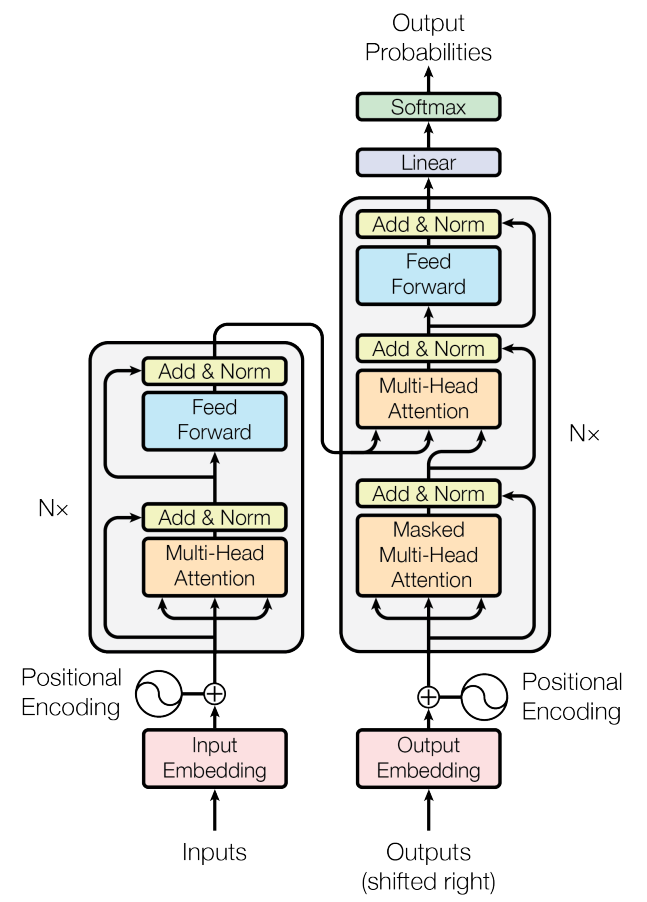

Next steps? Read this code: https://github.com/karpathy/minGPT/ and this one: https://github.com/karpathy/nanoGPT
They have a lot more teeth than the current one.